In [201]:
import pandas as pd
import numpy as np
import plotly
import plotly.io as pio
import plotly.graph_objs as go
import plotly.figure_factory as ff
from geopandas import GeoDataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.stats import pearsonr
from sklearn.cluster import KMeans
import geopandas as gpd
from shapely.geometry import Point, polygon

mpl.rcParams['agg.path.chunksize'] = 10000
plotly.offline.init_notebook_mode(connected=True)

In [2]:
permits = pd.read_csv("./data/DOB_Permit_Issuance.csv", low_memory=False)
permits.head()

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,...,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,PERMIT_SI_NO,LATITUDE,LONGITUDE,COUNCIL_DISTRICT,CENSUS_TRACT,NTA_NAME
0,BRONX,2102476,200,E 135TH STREET,240249842,1,A2,Y,02319,00120,...,PA,19355,6104011458,03/27/2019 12:00:00 AM,3608996,40.810699,-73.931313,8.0,51.0,Mott Haven-Port Morris
1,MANHATTAN,1090833,249,WEST 14 STREET,140818435,1,A3,Y,00764,00010,...,NY,11101,7183924921,03/27/2019 12:00:00 AM,3609359,40.739151,-74.001075,3.0,81.0,Hudson Yards-Chelsea-Flatiron-Union Square
2,MANHATTAN,1015903,20,WEST 36TH STREET,123372466,2,A2,Y,00837,00058,...,NY,10021,2122491550,03/27/2019 12:00:00 AM,3609159,40.750090,-73.984513,4.0,84.0,Midtown-Midtown South
3,QUEENS,4467709,14-30,BROADWAY,421105618,1,A2,Y,00529,00002,...,NY,11101,7184728000,03/27/2019 12:00:00 AM,3609358,40.765826,-73.932800,22.0,45.0,Astoria
4,QUEENS,4048873,42-06,108 STREET,421024689,1,A1,N,01986,00037,...,NY,11368,7182785872,03/27/2019 12:00:00 AM,3606599,40.749221,-73.858003,21.0,403.0,North Corona


### Let's look at the number of permits issued in NYC per year

In [3]:
permits_issued = permits[permits["Permit Status"] == "ISSUED"]
permits_issued["Filing_Date"] = pd.to_datetime(permits_issued["Filing Date"])
permits_issued["Filing_Year"] = permits_issued["Filing_Date"].dt.year
permits_issued["Issued_Date"] = pd.to_datetime(permits_issued["Issuance Date"])
permits_issued["Issued_Year"] = permits_issued["Issued_Date"].dt.year

In [4]:
permitTypeGroups = permits_issued.groupby(["Permit Type"])
plot1_data = []
permitTypeAbb = {"SG": "Sign", "PL": "Plumbing", "NB": "New Building", "FO": "Foundation", "EW": "Equipment Work", 
                 "EQ": "Construction Equipment", "DM": "Demolition", "AL": "Alteration"}
for permitType in permitTypeGroups.groups:
    subset = permitTypeGroups.get_group(permitType)
    temp = subset["Issued_Year"].value_counts().sort_index()
    plot1_data.append(go.Bar(x = temp.index.values, y = temp.values, name = permitTypeAbb[permitType]))

layout1 = go.Layout(
    barmode = 'stack',
    title = 'Number of Building permits issued in NYC per year (1989- Present)'
)
fig1 = go.Figure(data=plot1_data, layout=layout1)
plotly.offline.iplot(fig1, filename='stacked-bar')    

## Let\`s get the Number of permits issued per bourough in last 2 years.

In [5]:
issuedYearGroups = permits_issued.groupby(["Issued_Year"])
issuedYear2017 = issuedYearGroups.get_group(2017.0)
issuedYear2018 = issuedYearGroups.get_group(2018.0)
uniqueBorough = permits_issued["BOROUGH"].value_counts().index.values

trace1 = go.Bar(
    x=uniqueBorough,
    y=issuedYear2017["BOROUGH"].value_counts().values,
    name = "Year 2017"
)

trace2 = go.Bar(
    x=uniqueBorough,
    y=issuedYear2018["BOROUGH"].value_counts().values,
    name = "Year 2018"
)

layout2 = go.Layout(
    title = 'Number of Building permits issued per Borough in last 2 years'
)

fig2 = go.Figure(data=[trace1, trace2], layout=layout2)
plotly.offline.iplot(fig2, filename='grouped-bar')    
    

## Employment in Construction Industry vs Number of permits issued

In [6]:
#construction employment data obtained from https://www.labor.ny.gov/stats/lscesmaj.shtm
construction_employment = pd.read_csv('./data/cesempCSV.csv')
permits_per_year = permits_issued["Issued_Year"].value_counts().sort_index()

In [7]:
trace3 = go.Bar(
    x = construction_employment['Year'].values[1:],
    y = construction_employment['Ann Avg'].values[1:],
    name = "Employment",
    marker = dict(color='lightblue')
)
trace4 = go.Scatter(
    x = permits_per_year.index.values[:-1],
    y = permits_per_year.values[:-1],
    name = "permits",
    yaxis = 'y2',
    mode = 'lines+markers',
    marker = dict(color='red')
)
layout3 = go.Layout(
    title = 'NYC Construction Employment and Permits (1990-2018)',
    xaxis = dict(title = "Year"),
    yaxis = dict(title = "Construction Employment Annual Average"),
    yaxis2 = dict(overlaying='y', side = 'right', rangemode = "tozero", title = "Permits Issued"),
    legend=dict(x=1.1, y=1.1)
)

fig3 = go.Figure(data=[trace3, trace4], layout=layout3)
plotly.offline.iplot(fig3, filename='line-and-bar')    

In [8]:
a = np.flip(construction_employment['Ann Avg'].values[1:]).tolist()
b = permits_per_year.values[1:-1].tolist()
corr = pearsonr(b, a)
corr

(0.8863462525859336, 1.5918523701672004e-10)

### Observation:

#### From 2010 to 2018, Employment has steadily increased. Both Employment and permits issued decreased from 2009 to 2010. Besides, when the building permits steadily increased from 2010 to 2017, the construction employment also increased showing a strong correlation between them.


### Average permit issue times for various permit types? Which ones matter more?

In [9]:
permit_types = []
wait_times_1 = []
for permitType in permitTypeGroups.groups:
    subset = permitTypeGroups.get_group(permitType)
    wait_time = (subset['Issued_Date'] - subset['Filing_Date']).dt.days
    wait_times_1.append(wait_time.mean())
    permit_types.append(permitTypeAbb[permitType])

In [11]:
layout4 = go.Layout(
    title = 'Average wait time to issue permits for various permit types',
    xaxis = dict(title = "Days")
    
)
trace5 = [go.Bar(x = wait_times_1, y=permit_types, orientation='h')]
fig4 = go.Figure(data=trace5, layout=layout4)
plotly.offline.iplot(fig4, filename='horizontal-bar')

In [13]:
wait_time.head()

1872      0.0
1875      0.0
1971      0.0
12371     0.0
13084    48.0
dtype: float64

### Average wait time to issue permits for last 5 years

In [14]:
last5Years = [2014, 2015, 2016, 2017, 2018]
wait_times_2 = []
for year in last5Years:
    yearGroup = issuedYearGroups.get_group(year)
    wait_time = (yearGroup['Issued_Date'] - yearGroup['Filing_Date']).dt.days
    wait_times_2.append(wait_time.mean())

In [15]:
layout5 = go.Layout(
    title = 'Average wait time to issue permits for last 5 years (2014-2018)',
    xaxis = dict(title = "Average wait time to issue permit (in Days)"),
    yaxis = dict(title = "Permit Type")
)
trace6 = [go.Bar(x = wait_times_2, y=last5Years, orientation='h')]
fig5 = go.Figure(data=trace6, layout=layout5)
plotly.offline.iplot(fig5, filename='horizontal-bar2')

## spatial plot based on permits issued per zipcode

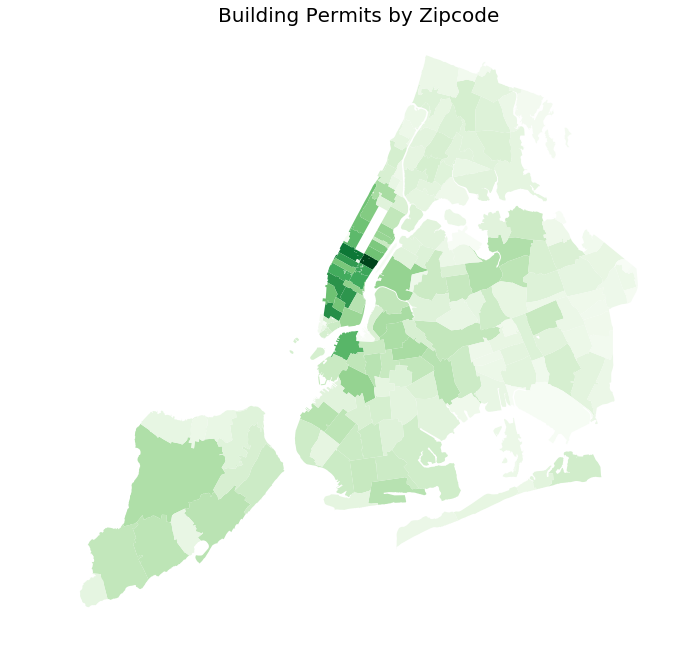

In [76]:
zipcodes_NYC = GeoDataFrame.from_file('./data/ZIP_CODE_040114.shp')
zipcodes_NYC["ZIPCODE"] = zipcodes_NYC["ZIPCODE"].astype(int)
permits_per_zip = permits_issued["Zip Code"].value_counts()
permits_per_zip = permits_per_zip.to_frame(name='count_permits_issued')
permits_per_zip = permits_per_zip.reset_index()
zipmap_df = GeoDataFrame(permits_per_zip.merge(zipcodes_NYC, how='left', left_on='index', right_on='ZIPCODE'))
zipmap_df = zipmap_df.dropna()
zipmap_df.to_csv("./output/zipmap1.csv")

fig, ax = plt.subplots(figsize = (11,12))
zipmap_df.plot(column='count_permits_issued', cmap='Greens',alpha=1,linewidth=0.1,ax=ax)
plt.title('Building Permits by Zipcode', size=20)
plt.axis('off')
plt.show()

## Demolition permits issued in 2018

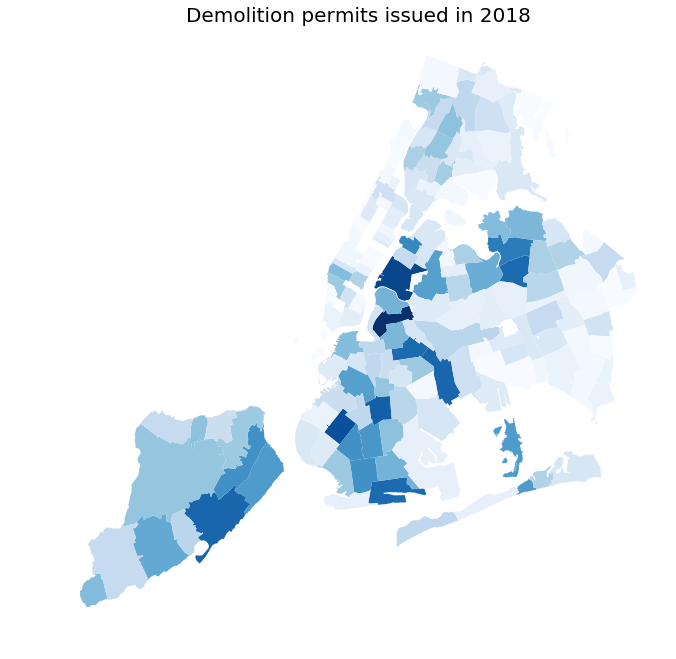

In [79]:
Demolition_permits = permits_issued[permits_issued["Permit Type"] == "DM"]
Demolition_permits_2018 = Demolition_permits[Demolition_permits["Issued_Year"] == 2018]
DE_per_zip_2018 = Demolition_permits_2018["Zip Code"].value_counts()
DE_per_zip_2018 = DE_per_zip_2018.to_frame(name='Demolition_permits_2018')
DE_per_zip_2018 = DE_per_zip_2018.reset_index()
zipmap_df4 = GeoDataFrame(DE_per_zip_2018.merge(zipcodes_NYC, how='left', left_on='index', right_on='ZIPCODE'))
zipmap_df4 = zipmap_df4.dropna()

fig, ax = plt.subplots(figsize = (11,12))
zipmap_df4.plot(column='Demolition_permits_2018', cmap='Blues',alpha=1,linewidth=0.1,ax=ax)
plt.title('Demolition permits issued in 2018', size=20)
plt.axis('off')
plt.show()

#### Observation: Lower and Midtown manhattan areas have high concentration of permits

## Combining permits data with 311 calls data

In [ ]:
calls_311 = pd.read_csv('./data/311_Noise_Complaints.csv', low_memory=False)
calls_311["Created_Date"] = pd.to_datetime(calls_311["Created Date"])
calls_311["Created_Year"] = calls_311["Created_Date"].dt.year
CO_calls = calls_311[(calls_311["Descriptor"] == "Noise: Construction Equipment (NC1)") | (calls_311["Descriptor"] == "Noise: Construction Before/After Hours (NM1)")]
CE_calls = calls_311[calls_311["Descriptor"] == "Noise: Construction Equipment (NC1)"]
CA_calls = calls_311[calls_311["Descriptor"] == "Noise: Construction Before/After Hours (NM1)"]
CE_calls_per_year = CE_calls["Created_Year"].value_counts().sort_index()
CE_permits = permits_issued[permits_issued["Permit Type"] == "EW"]
CE_permits_per_year = CE_permits["Issued_Year"].value_counts().sort_index()

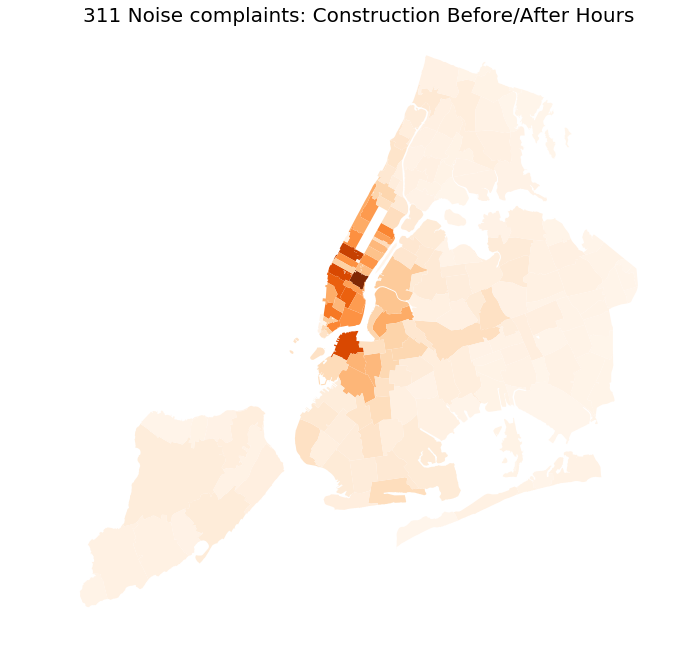

In [75]:
CA_per_zip = CA_calls["Incident Zip"].value_counts()
CA_per_zip = CA_per_zip.to_frame(name='count_311_calls')
CA_per_zip = CA_per_zip.reset_index()
zipmap_df3 = GeoDataFrame(CA_per_zip.merge(zipcodes_NYC, how='left', left_on='index', right_on='ZIPCODE'))
zipmap_df3 = zipmap_df3.dropna()

fig, ax = plt.subplots(figsize = (11,12))
zipmap_df3.plot(column='count_311_calls', cmap='Oranges',alpha=1,linewidth=0.1,ax=ax)
plt.title('311 Noise complaints: Construction Before/After Hours', size=20)
plt.axis('off')
plt.show()

In [54]:
permits_vs_311calls = pd.merge(zipmap_df[["ZIPCODE", "count_permits_issued"]], zipmap_df3[["ZIPCODE", "count_311_calls"]], on="ZIPCODE")
corr2 = pearsonr(permits_vs_311calls["count_permits_issued"], permits_vs_311calls["count_311_calls"])
corr2

(0.8592312377657579, 3.4522225899634146e-76)

## Clustering New Building Residential permits by building type (1-family, 2-family)

In [196]:
permits_RNB = permits_issued[(permits_issued["Residential"] == "YES") & (permits_issued["Permit Type"] == "NB")]
permits_RNB = permits_RNB.dropna(subset = ["LATITUDE", "LONGITUDE", "Bldg Type"])

X = permits_RNB[["Bldg Type"]]
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)
labels = kmeans.predict(X)
permits_RNB["cluster"] = labels 

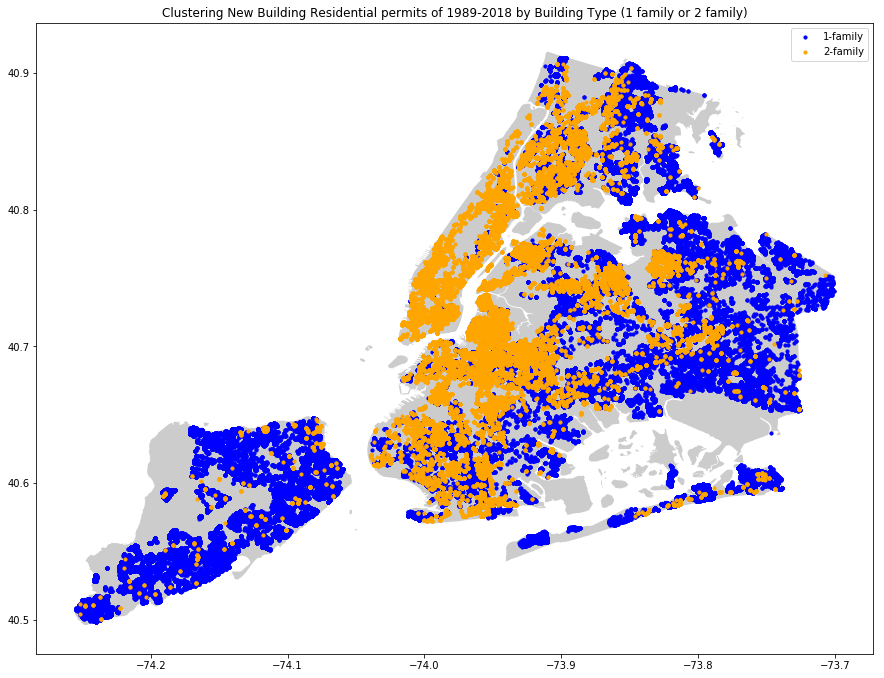

In [198]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(permits_RNB["LONGITUDE"], permits_RNB["LATITUDE"])]
geo_df = gpd.GeoDataFrame(permits_RNB, crs=crs, geometry=geometry)

nyc_shapefile = gpd.read_file('./data/geo_export_33e5fa15-1c53-4314-b7fa-e40737b55b88.shp')
fig, ax = plt.subplots(figsize = (15,15))
nyc_shapefile.plot(ax=ax, alpha = 0.4, color="grey")
color = ["blue", "orange"]
for i in range(num_clusters):
    cluster = geo_df[geo_df["cluster"] == i]
    cluster.geometry.plot(ax=ax, markersize=10, marker="o", color= color[i])
plt.title("Clustering New Building Residential permits of 1989-2018 by Building Type (1 family or 2 family)")    
plt.legend(("1-family", "2-family"))
plt.show()

In [199]:
permits_RNB_2017_2018 = permits_RNB[permits_RNB["Issued_Year"] >= 2017]

X1 = permits_RNB_2017_2018[["Bldg Type"]]
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X1)
labels1 = kmeans.predict(X1)
permits_RNB_2017_2018["cluster"] = labels1 

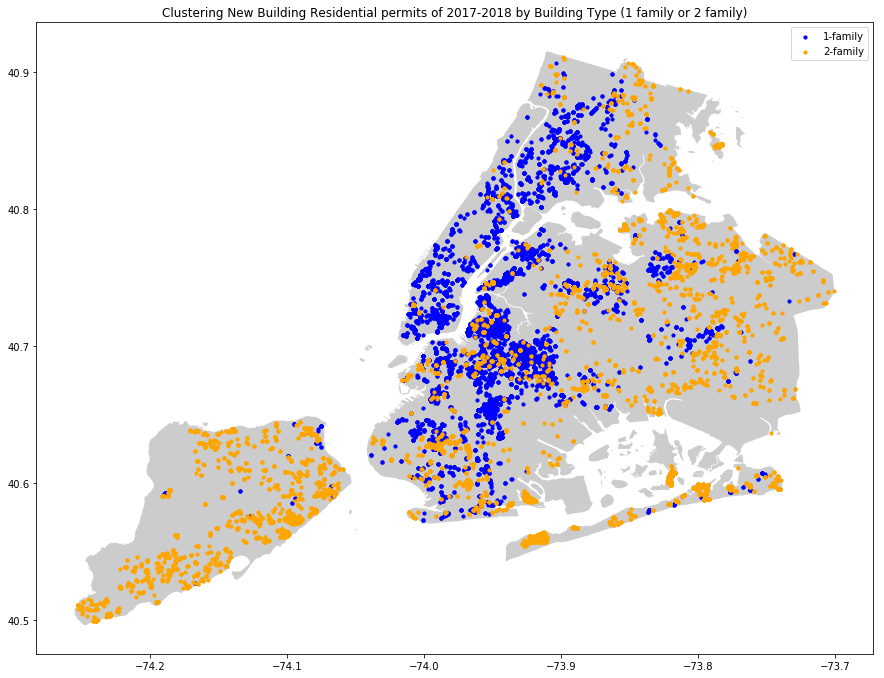

In [200]:
crs = {'init': 'epsg:4326'}
geometry2 = [Point(xy) for xy in zip(permits_RNB_2017_2018["LONGITUDE"], permits_RNB_2017_2018["LATITUDE"])]
geo_df2 = gpd.GeoDataFrame(permits_RNB_2017_2018, crs=crs, geometry=geometry2)

fig, ax = plt.subplots(figsize = (15,15))
nyc_shapefile.plot(ax=ax, alpha = 0.4, color="grey")
color = ["blue", "orange"]
for i in range(num_clusters):
    cluster = geo_df2[geo_df2["cluster"] == i]
    cluster.geometry.plot(ax=ax, markersize=10, marker="o", color = color[i])
plt.title("Clustering New Building Residential permits of 2017-2018 by Building Type (1 family or 2 family)")
plt.legend(("1-family", "2-family"))
plt.show()